##### Adrian Poniatowski 401346 WEAIiIB AiR AGH

# Bayesian models for predicting energy balance of a home with solar panels
<br><br><br>

Prepare environment

In [41]:
# Import libraries

from cmdstanpy import CmdStanModel
import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython import display


# Prepare global variables and functions
MODEL_PATH_1_PROD = "model1/model1_produkcja.stan"
MODEL_PATH_1_ZUZ = "model1/model1_zuzycie.stan"
MODEL_PATH_1_PROD_PPC = "model1/model1_produkcja_ppc.stan"
MODEL_PATH_1_ZUZ_PPC = "model1/model1_zuzycie_ppc.stan"

MODEL_PATH_2_PROD = "model2/model2_produkcja.stan"
MODEL_PATH_2_PROD_PPC = "model2/model2_produkcja_ppc.stan"

DATA = pd.read_excel("data/PV_energy.xlsx")

## 1. Problem formulation

Photovoltaics is an inexhaustible source of energy that doesn't pollute the environment, is durable, and makes you independent from annual electricity price increases. This means that investing in a photovoltaic installation not only allows you to stabilize your energy expenses by generating your own electricity but also generates savings for decades.

However, the production of electrical energy is influenced by many factors, so we decided to analyze their individual impact. Additionally, to make it more than just purely statistical data that may not mean much to people unfamiliar with the topic, we added data and energy consumption predictions for the same household for which the energy is being produced using solar panels.

The whole problem initially involved gathering real data, which was possible thanks to having photovoltaic panels and a specialized application. The application showed how many kilowatt-hours were produced each day and how much was consumed by the household. Additionally, in specialized weather services, we found information regarding the parameters that have the greatest impact (according to sources) on solar energy production. In the case of consumption, these parameters are certainly not perfectly chosen, but as mentioned earlier, the main idea of the project was to predict production, while consumption is used to better illustrate the values.

The created models and obtained results can help people considering photovoltaic panels in making decisions regarding investments. The project provides the opportunity to obtain at least partial answers to whether such an investment can be profitable under the conditions prevailing in Poland. It is worth noting that the data comes from the Lublin Voivodeship, and there may be slight differences between regions within the country.

Below is a visible DAG diagram for our project.

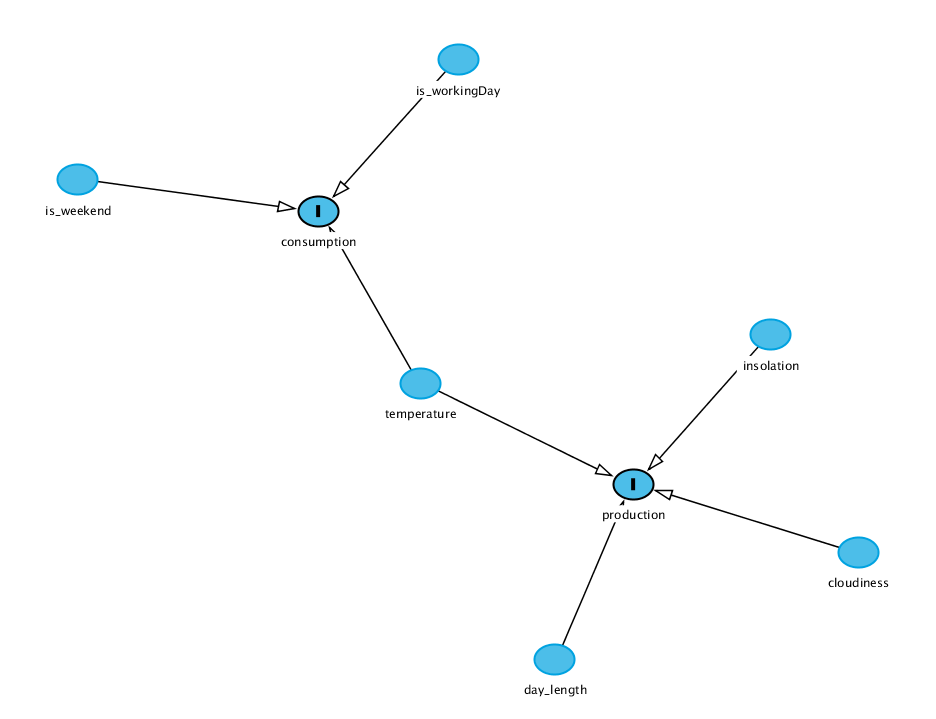

In [42]:
display.Image("data/dagitty-model.png", width=600, height=600)

When it comes to confounders, the only case we have in our project, although difficult to categorize unambiguously (whether a fork or something), is the relationship between the variables "is_weekend" and "is_workingDay." Specifically, if one variable has a value of 1, the other is 0, and vice versa. These variables convey information about the type of day of the week.

Another confounder that initially appeared in our project and can be seen in the DAG is "temperature". The type of this confounder is a "fork", which corresponds to omitted variable bias. Due to the high variability and inaccuracy of the data, we decided to split one model that predicted both energy consumption and production into two separate models, thus avoiding the problem.

## 2. Data Preprocessing
<br>
The data was obtained using the manufacturer's photovoltaic panel application. The application tracked the production and consumption of electrical energy over a six-month period, from January to June, allowing for the consideration of different weather conditions in the data. Each row represents data from a single day and includes the following information:

<ul>
    <li>Day of the week
    <li>Consumption (kWh)
    <li>Production (kWh)
    <li>Average temperature (C)
    <li>Average sunlight (W/m^2)
    <li>Average cloudiness (%)
    <li>Day length (h)
</ul>
The collected data is fully complete (no missing values). Additionally, it did not require many preprocessing steps. The only necessary step was encoding the day of the week. Two new dummy columns were created: "Weekend" and "Working_week," each containing binary information indicating whether it is currently a weekend or not.

In [43]:
DATA['Weekend'] = [1 if day in ['sobota', 'niedziela'] else 0 for day in DATA['dzień tygodnia']]
DATA['Working_week'] = [0 if day in ['sobota', 'niedziela'] else 1 for day in DATA['dzień tygodnia']]
DATA

,data,dzień tygodnia,zużycie (kWh),produkcja (kWh),średnia temperatura (°C),średnie nasłonecznienie (W/m^2),średnie zachmurzenie (%),wschód słońca,zachód słońca,długość dnia,Weekend,Working_week
0,2023-01-05,czwartek,8.300000,1.2,6.3,28.65,100.000000,07:42:00,15:40:00,7.966667,0,1
1,2023-01-06,piątek,9.100000,1.1,-0.3,66.78,100.000000,07:41:00,15:41:00,8.000000,0,1
2,2023-01-07,sobota,16.100000,2.2,2.8,110.11,87.400000,07:41:00,15:42:00,8.016667,1,0
3,2023-01-08,niedziela,13.700000,2.5,1.1,88.56,44.000000,07:40:00,15:44:00,8.066667,1,0
4,2023-01-09,poniedziałek,8.500000,1.9,5.0,25.28,60.500000,07:40:00,15:45:00,8.083333,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
147,2023-06-01,czwartek,6.490205,31.8,20.4,334.88,26.944444,04:18:00,20:48:00,16.500000,0,1
148,2023-06-02,piątek,7.614642,14.1,11.3,209.17,50.166667,04:17:00,20:50:00,16.550000,0,1
149,2023-06-03,sobota,12.063538,33.1,12.7,349.10,2.555556,04:17:00,20:51:00,16.566667,1,0
150,2023-06-04,niedziela,11.793975,32.5,16.5,344.89,36.555556,04:16:00,20:52:00,16.600000,1,0



The next step in data processing was to divide them into separate DataFrames, where each DataFrame contains the data needed for a specific model.

The last step involved data normalization, as the data contained values with different units. Normalization was performed by subtracting the mean and dividing by the standard deviation.

In [44]:
# Prepare data

X = DATA[['Weekend', 'Working_week', 'średnia temperatura (°C)', 'średnie nasłonecznienie (W/m^2)','średnie zachmurzenie (%)','długość dnia']]
X_zuzycie = X.iloc[:, :3]
X_produkcja = X.iloc[:, 2:]

X_zuzycie_norm = (X_zuzycie - X_zuzycie.mean()) / X_zuzycie.std()
X_produkcja_norm = (X_produkcja - X_produkcja.mean()) / X_produkcja.std()

N_days = len(DATA['data'])
data_sim_zuzycie = {'n': N_days,
            'k_zuzycie': len(X_zuzycie_norm.columns),
            'X_zuzycie': X_zuzycie_norm,
            'zuzycie_energii':DATA['zużycie (kWh)']}

data_sim_prod = {'n': N_days,
            'k_produkcja': len(X_produkcja_norm.columns),
            'X_produkcja': X_produkcja_norm,
            'produkcja_energii':DATA['produkcja (kWh)']}

data_sim_model2 = {'n': N_days,
                'k_produkcja': len(X_produkcja_norm.columns)-1,
                'X_produkcja': X_produkcja_norm.iloc[:, 1:],
                'produkcja_energii':DATA['produkcja (kWh)']}

X_produkcja_norm

,średnia temperatura (°C),średnie nasłonecznienie (W/m^2),średnie zachmurzenie (%),długość dnia
0,-0.054805,-1.178747,1.111168,-1.578191
1,-1.088278,-0.800123,1.111168,-1.566063
2,-0.602859,-0.369863,0.706574,-1.560000
3,-0.869057,-0.583851,-0.687025,-1.541808
4,-0.258368,-1.212211,-0.157200,-1.535744
...,...,...,...,...
147,2.153069,1.862066,-1.234689,1.526489
148,0.728129,0.613787,-0.489010,1.544680
149,0.947350,2.003269,-2.017830,1.550744
150,1.542380,1.961464,-0.926070,1.562872


<b>FUNCTIONS<b>

In [45]:
def scatter_hist_display(val_mat, y_values):
    fig, axs = plt.subplots(2, len(val_mat.columns))
    fig.set_size_inches(5*len(val_mat.columns), 10)

    for i, col in enumerate(val_mat.columns):
        axs[0, i].scatter(val_mat[col], y_values)
        axs[0, i].set_title(col)
        axs[0, i].set_ylabel(y_values.name)
        axs[0, i].grid()

        axs[1, i].hist(val_mat[col])
        axs[1, i].set_ylabel("Density")
        axs[1, i].set_xlabel(col)
        axs[1, i].grid()
    
def scatter_compare_display(val_mat, y_values_orig, y_values_gen):
    fig, axs = plt.subplots(1, len(val_mat.columns))
    fig.set_size_inches(5*len(val_mat.columns), 5)

    for i, col in enumerate(val_mat.columns):
        axs[i].scatter(val_mat[col], y_values_orig, alpha=0.8, label="Original")
        axs[i].scatter(val_mat[col], y_values_gen, alpha=0.8, label="Generated")
        axs[i].set_title(col)
        axs[i].set_ylabel(y_values_orig.name)
        axs[i].set_xlabel(col)
        axs[i].grid()
        axs[i].legend()


def hist_compare(y_real, y_gen):
    plt.figure()
    y_real.hist(alpha=0.5, label="Real")
    y_gen.hist(alpha=0.5, label="Generated")
    plt.legend()
    plt.title("Generated samples")
    plt.xlabel(y_real.name)
    plt.grid()
    plt.show()


def samples_hist(y_real, df_pred, column_name, idxs):
    plt.figure()
    fig, axs = plt.subplots(2, 3)
    fig.set_size_inches(15, 10)

    for i, idx in enumerate(idxs):
        axs[i//3, i%3].hist(df_pred[f"{column_name}[{idx}]"])
        axs[i//3, i%3].axvline(y_real[idx-1], color='r', label = f"Observed: {np.round(y_real[idx-1],2)}")
        axs[i//3, i%3].axvline(df_pred[f"{column_name}[{idx}]"].mean(), color='k', label = f"Generated: {np.round(df_pred[f'{column_name}[{idx}]'].mean(),2)}")
        axs[i//3, i%3].set_title(f"Sample number {idx}")
        axs[i//3, i%3].set_ylabel("Density")
        axs[i//3, i%3].legend()
        axs[i//3, i%3].grid()
    plt.show()

## 3. Model

Before proceeding to create the models, we decided to analyze the collected data.

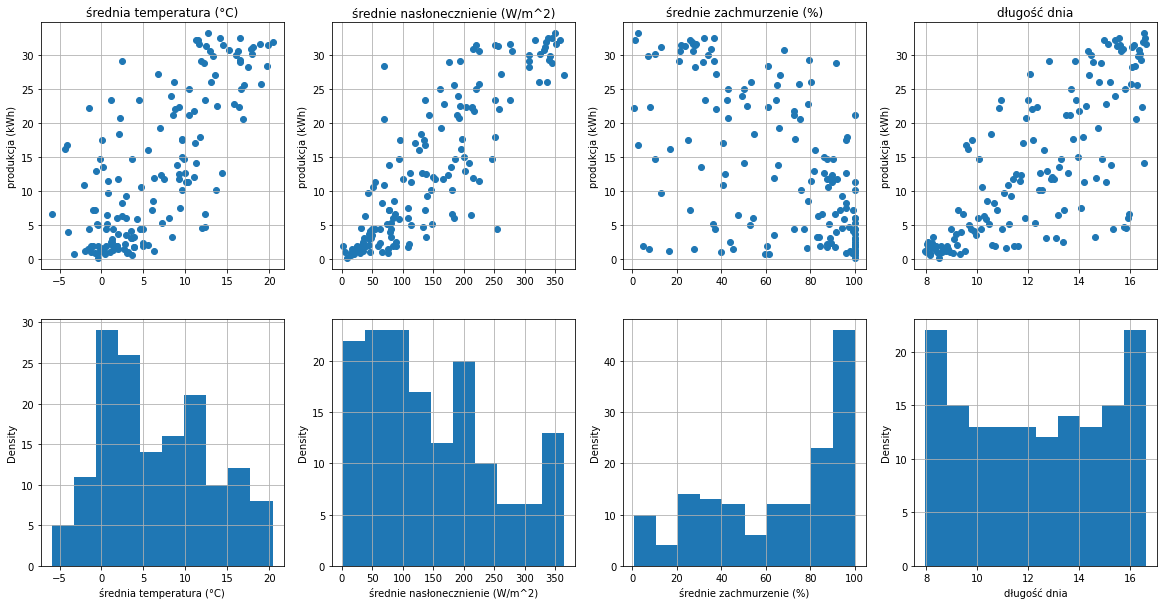

In [46]:
scatter_hist_display(X_produkcja, DATA["produkcja (kWh)"])

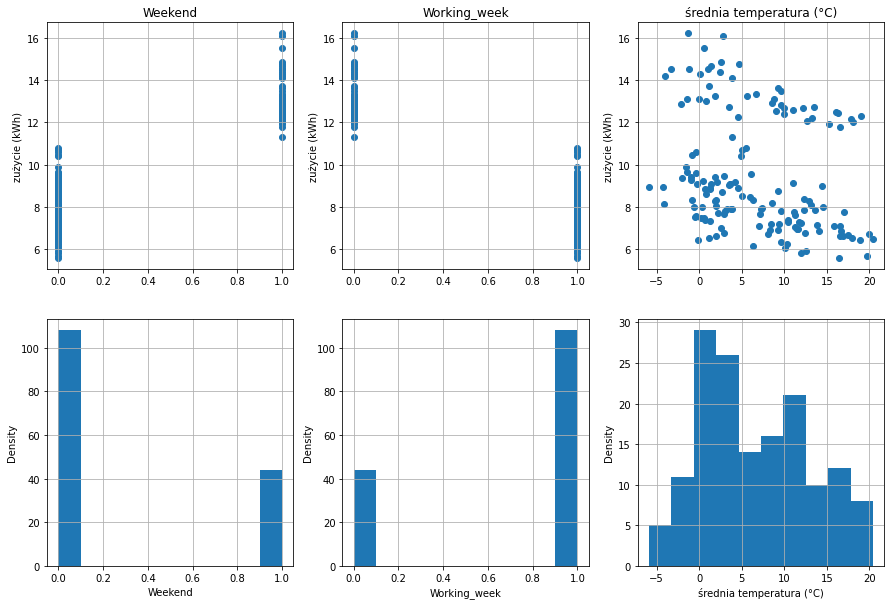

In [47]:
scatter_hist_display(X_zuzycie, DATA["zużycie (kWh)"])

The above charts allowed us to observe certain linear relationships between predictors and production as well as consumption. Based on these observations, we deemed a linear model potentially suitable for this problem.

The first model is a linear model with the mean calculated based on beta coefficients, actual predictor values, and the intercept alpha. Then, a normal distribution is used with the obtained mean and standard deviation in the form of a value drawn from an exponential distribution. The first production model includes the following predictors: sunlight, cloudiness, temperature, and day length. These predictors were selected based on articles related to photovoltaics found on the internet.

The second model, similar to the first one, differs in the number of predictors used, specifically considering sunlight, cloudiness, and day length but not temperature. Based on observations, we deemed it worthwhile to check if temperature has an impact on energy production.

In an effort to present the overall energy data in a more accessible way and having data that allows us to somewhat predict energy consumption, we decided to create an experimental energy consumption model. Expectations for this model were not high since the only available data that could be utilized were the day of the week and temperature. During data collection, we noticed that significantly higher consumption occurs on weekends (likely due to a higher presence of people in the household and cleaning activities often performed on those days). Additionally, energy consumption is higher at lower temperatures (heating requirements).

## 4. Priors

The selected priors for the models are the parameters of slope in the linear function - beta, the intercept - alpha, and a prior for the standard deviation - sigma. For the coefficients of the linear function, a normal distribution was chosen as the prior because we do not have any knowledge suggesting the use of a different distribution. As for the standard deviation parameter - sigma, we assumed an exponential distribution for it.

For all models we selected specific mean and standard deviation values for the priors of the beta, alpha, and sigma parameters. These values are based on our current knowledge of the discussed domain and determine the impact of each predictor on the final outcome.

<br><br>
### Model1 Production PPC


In [ ]:
model1_ppc = CmdStanModel(stan_file=MODEL_PATH_1_PROD_PPC)

sim1 = model1_ppc.sample(data=data_sim_prod,
                        seed=123)

df_1_ppc = sim1.draws_pd()

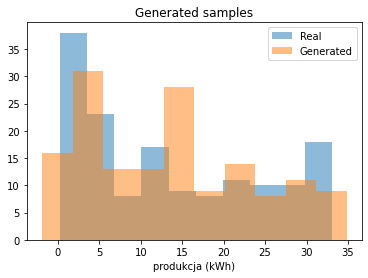

In [49]:
hist_compare(DATA["produkcja (kWh)"], df_1_ppc.iloc[0][8:])

From the above chart, it can be inferred that the chosen prior values allow for generating values that describe the real data. The samples generated from the prior in the model make sense in terms of the distribution of values.

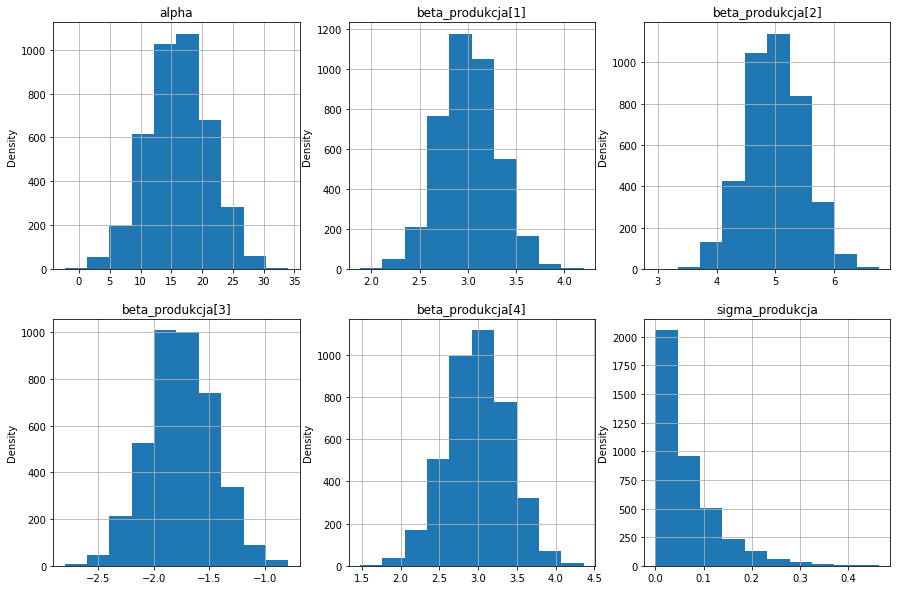

In [50]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(15, 10)

for i, col in enumerate(["alpha", "beta_produkcja[1]", "beta_produkcja[2]", "beta_produkcja[3]", "beta_produkcja[4]", "sigma_produkcja"]):
    axs[i//3, i%3].hist(df_1_ppc[col])
    axs[i//3, i%3].set_ylabel("Density")
    axs[i//3, i%3].set_title(col)
    axs[i//3, i%3].grid()

The histograms created from the generated points confirm that the prior distributions align with the initial assumptions.

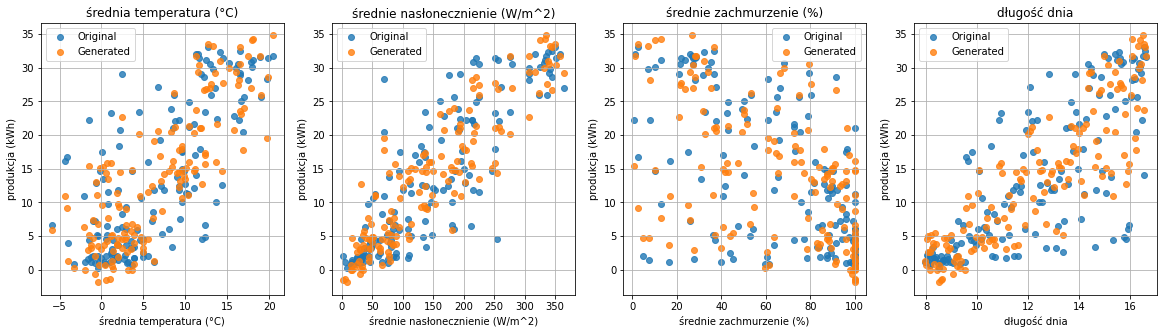

In [51]:
scatter_compare_display(X_produkcja, DATA["produkcja (kWh)"], df_1_ppc.iloc[0][8:])

Again, the samples generated from the prior in the model make sense in terms of the distribution of values.

<br><br>
### Model1 Consumption PPC

In [ ]:
model1_ppc_zuz = CmdStanModel(stan_file=MODEL_PATH_1_ZUZ_PPC)

sim2 = model1_ppc_zuz.sample(data=data_sim_zuzycie,
                        seed=123)

df_1_ppc_zuz = sim2.draws_pd()

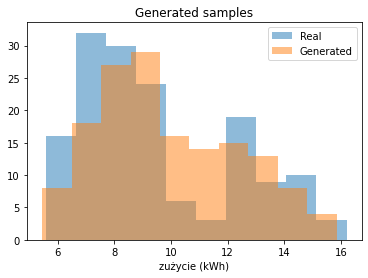

In [53]:
hist_compare(DATA["zużycie (kWh)"], df_1_ppc_zuz.iloc[0][7:])

From the above chart, it can be inferred that the chosen prior values allow for generating values that describe the real data. The samples generated from the prior in the model make sense in terms of the distribution of values.

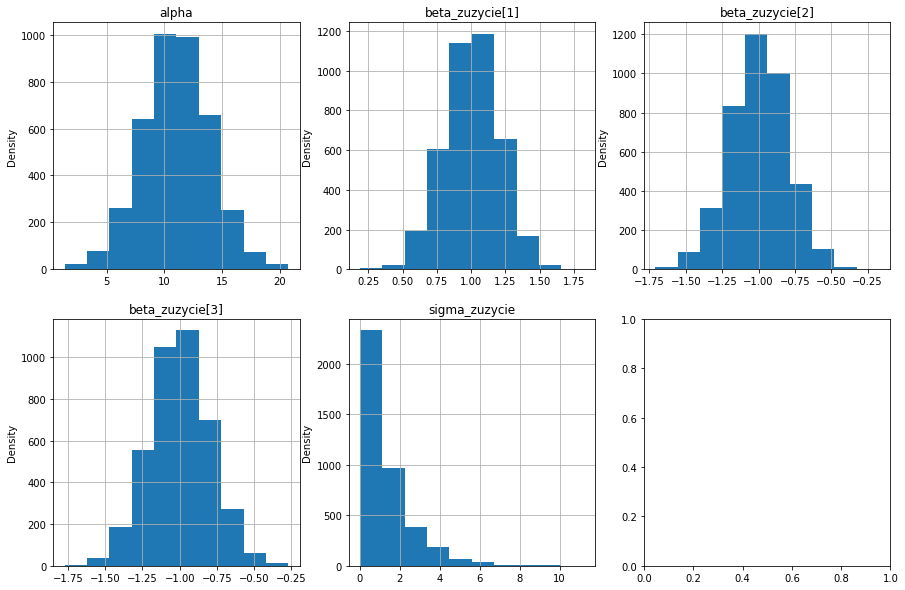

In [54]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(15, 10)

for i, col in enumerate(["alpha", "beta_zuzycie[1]", "beta_zuzycie[2]", "beta_zuzycie[3]", "sigma_zuzycie"]):
    axs[i//3, i%3].hist(df_1_ppc_zuz[col])
    axs[i//3, i%3].set_ylabel("Density")
    axs[i//3, i%3].set_title(col)
    axs[i//3, i%3].grid()

The histograms created from the generated points confirm that the prior distributions align with the initial assumptions.

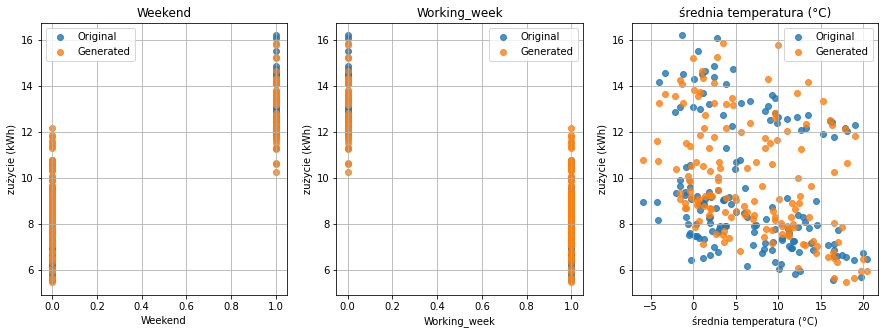

In [55]:
scatter_compare_display(X_zuzycie, DATA["zużycie (kWh)"], df_1_ppc_zuz.iloc[0][7:])

Again, the samples generated from the prior in the model make sense in terms of the distribution of values.

<br><br>
### Model2


In [ ]:
model2_ppc = CmdStanModel(stan_file=MODEL_PATH_2_PROD_PPC)

sim3 = model2_ppc.sample(data=data_sim_model2,
                        seed=123)

df_3_ppc = sim3.draws_pd()

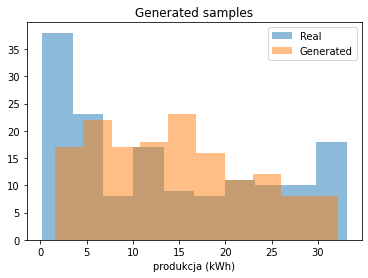

In [58]:
hist_compare(DATA["produkcja (kWh)"], df_3_ppc.iloc[0][7:])

From the above chart, it can be inferred that the chosen prior values allow for generating values that describe the real data. The samples generated from the prior in the model make sense in terms of the distribution of values.

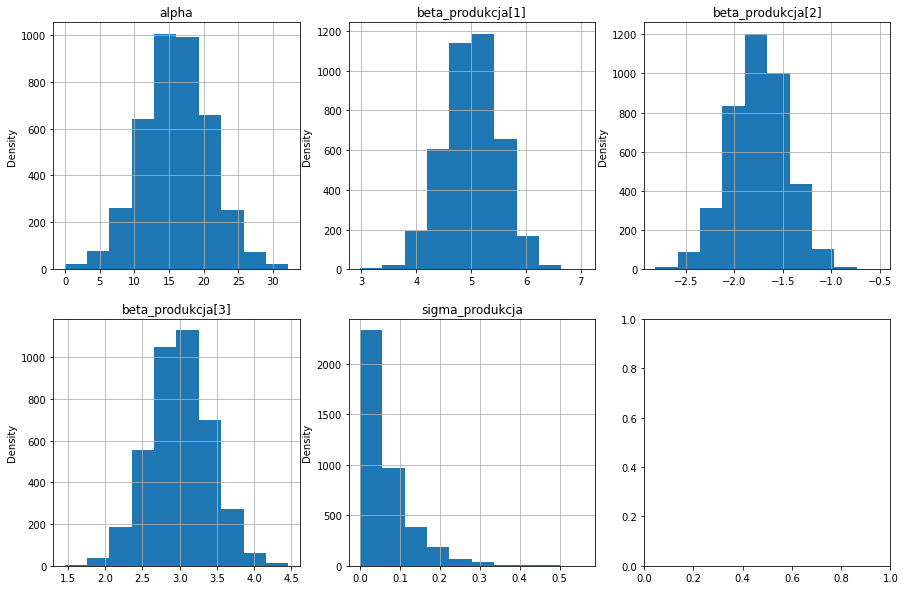

In [59]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(15, 10)

for i, col in enumerate(["alpha", "beta_produkcja[1]", "beta_produkcja[2]", "beta_produkcja[3]", "sigma_produkcja"]):
    axs[i//3, i%3].hist(df_3_ppc[col])
    axs[i//3, i%3].set_ylabel("Density")
    axs[i//3, i%3].set_title(col)
    axs[i//3, i%3].grid()

The histograms created from the generated points confirm that the prior distributions align with the initial assumptions.

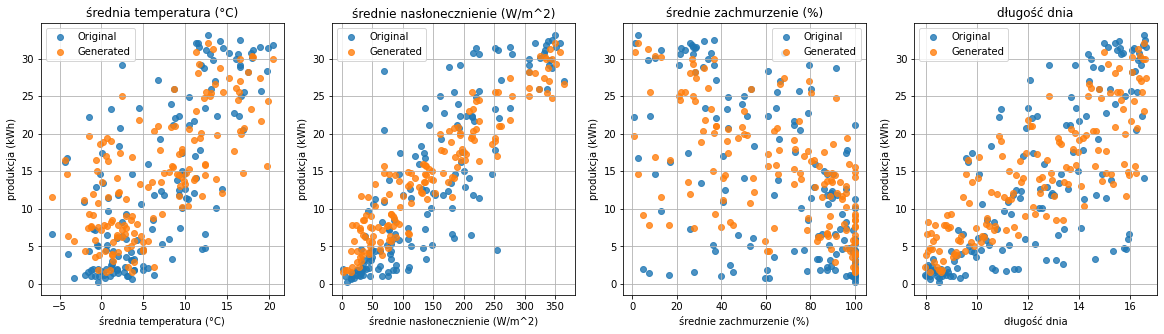

In [60]:
scatter_compare_display(X_produkcja, DATA["produkcja (kWh)"], df_3_ppc.iloc[0][7:])

Again, the samples generated from the prior in the model make sense in terms of the distribution of values.

## 5. Posterior analysis (model 1)
<br><br>
### Model1 production

In [ ]:
# Compile model of production

model1_prod = CmdStanModel(stan_file=MODEL_PATH_1_PROD)

sim1_prod = model1_prod.sample(data=data_sim_prod,
                                seed=123)

df_1_prod = sim1_prod.draws_pd()

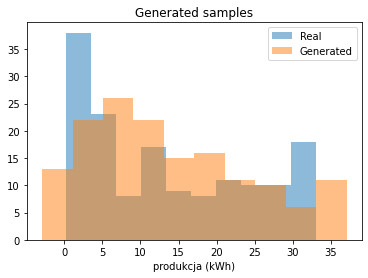

In [62]:
hist_compare(DATA["produkcja (kWh)"], df_1_prod.iloc[0][165:317])

From the above histogram, it can be concluded that the posterior model is able to describe the observed data. However, the model is not perfect as it may generate values that are too large or negative, which is physically unrealistic. The model did not have any constraints applied, which allowed for smooth sampling, but it affected the results (generated data).

It is important to note that the model's ability to describe the data should be interpreted with caution, considering the limitations and potential unrealistic values it may generate.

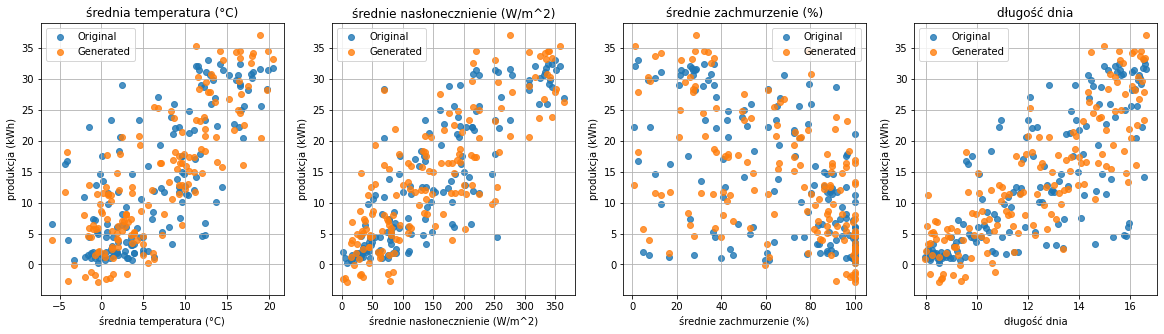

In [63]:
scatter_compare_display(X_produkcja, DATA["produkcja (kWh)"], df_1_prod.iloc[0][165:317])

From the above scatter plots, we can observe that the model is capable of generating realistic samples. In comparison to the prior model, it is able to generate values that deviate more from the norm.

This suggests that the posterior model has learned from the data and can generate samples that capture the variability and outliers present in the observed data.

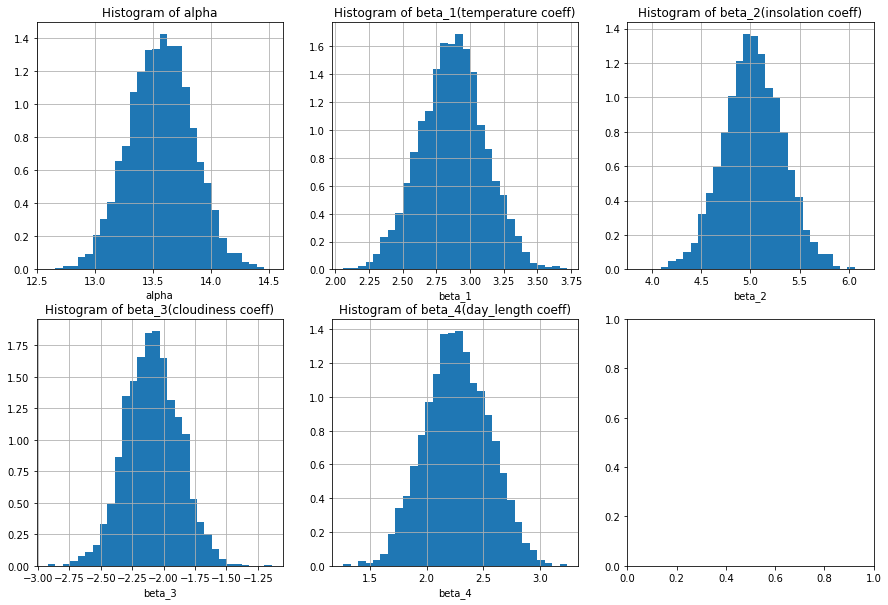

In [64]:
alpha = sim1_prod.stan_variable('a_produkcja')
beta = sim1_prod.stan_variable('beta_produkcja')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].hist(alpha, bins=30, density=True)
axes[0, 0].set_title(f'Histogram of alpha')
axes[0, 0].set_xlabel(f'alpha')
axes[0, 0].grid()

for i, el in enumerate(["temperature coeff", "insolation coeff", "cloudiness coeff", "day_length coeff"]):
    axes[(i+1)//3, (i+1)%3].hist(beta[:, i], bins=30, density=True)
    axes[(i+1)//3, (i+1)%3].set_title(f'Histogram of beta_{i+1}({el})')
    axes[(i+1)//3, (i+1)%3].set_xlabel(f'beta_{i+1}')
    axes[(i+1)//3, (i+1)%3].grid()

plt.show()

The histograms created from the generated points confirm that the posterior distributions align with the initial assumptions. Posterior model parameter values are slightly shifted in contrast to our prior assumptions, so we can conclude that model learned on input data and corrected its parameter values.

<Figure size 432x288 with 0 Axes>

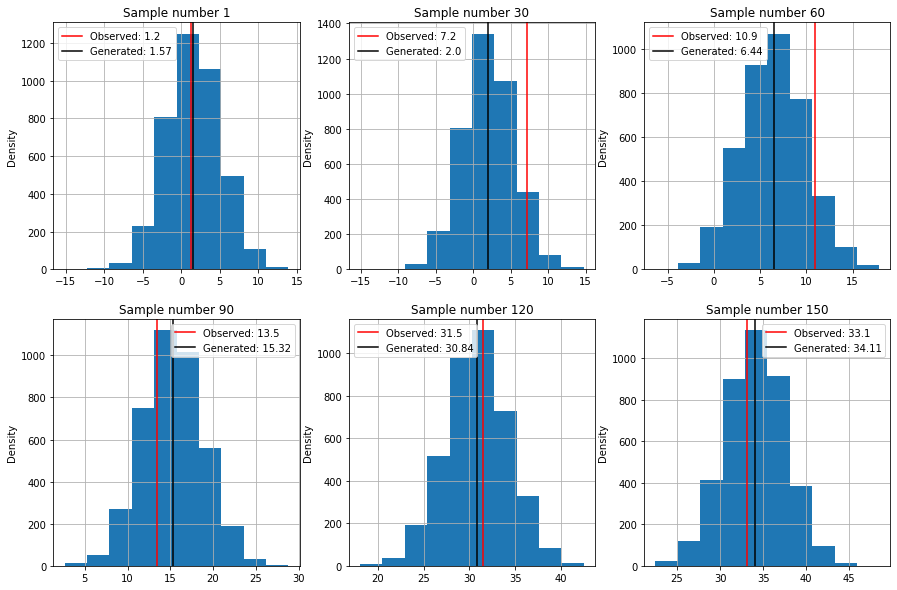

In [65]:
samples_hist(DATA['produkcja (kWh)'], df_1_prod, 'y_produkcja_pred_test', [1,30,60,90,120,150])

Above we created plots of generated values for specific input data. We plotted histograms of values for one day in every month of our data, so we could see the influence of predictors on output. As we can see generated data is overall consistent with real values.

<br><br>
### Model1 consumption - experimental model (not model2)

In [ ]:
# Compile model of consumption

model1_zuz = CmdStanModel(stan_file=MODEL_PATH_1_ZUZ)

sim1_zuz = model1_zuz.sample(data=data_sim_zuzycie, 
                                seed=123)

df_1_zuz = sim1_zuz.draws_pd()

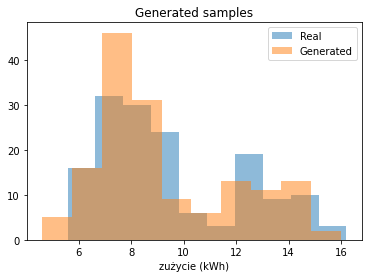

In [67]:
hist_compare(DATA["zużycie (kWh)"], df_1_zuz.iloc[0][164:])

To our surprise, generated samples are clearly consistent with real data, so posterior model describes the data better than expected.

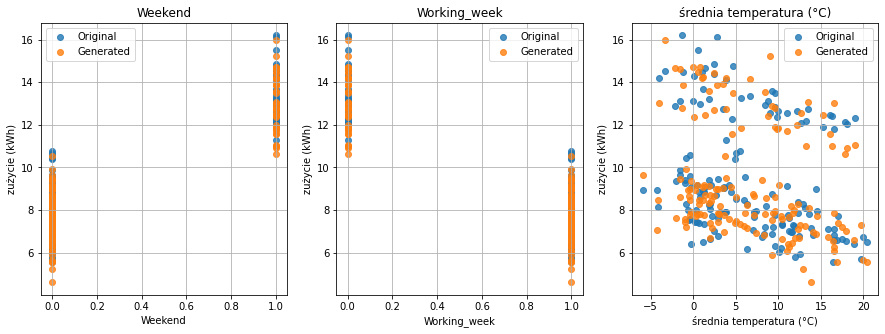

In [68]:
scatter_compare_display(X_zuzycie, DATA["zużycie (kWh)"], df_1_zuz.iloc[0][164:])

Again we can see that model learned on the data and describes it pretty well. Additionally there is clear improvement over model based only on our prior assumptions.

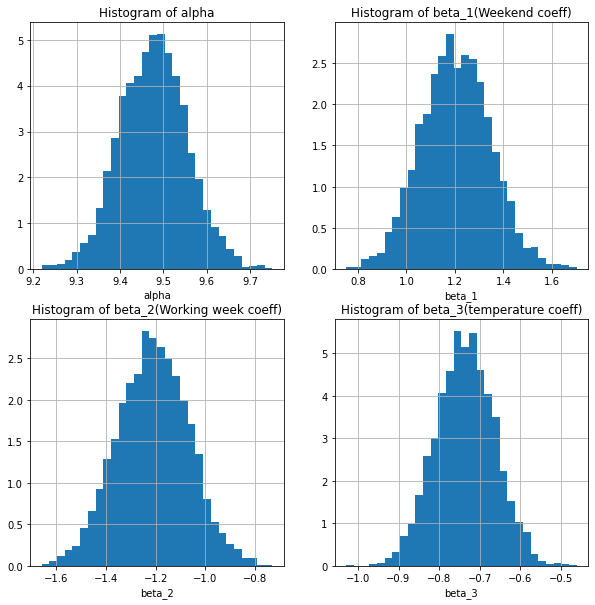

In [69]:
alpha = sim1_zuz.stan_variable('a_zuzycie')
beta = sim1_zuz.stan_variable('beta_zuzycie')

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].hist(alpha, bins=30, density=True)
axes[0, 0].set_title(f'Histogram of alpha')
axes[0, 0].set_xlabel(f'alpha')
axes[0, 0].grid()

for i, el in enumerate(["Weekend coeff", "Working week coeff", "temperature coeff"]):
    axes[(i+1)//2, (i+1)%2].hist(beta[:, i], bins=30, density=True)
    axes[(i+1)//2, (i+1)%2].set_title(f'Histogram of beta_{i+1}({el})')
    axes[(i+1)//2, (i+1)%2].set_xlabel(f'beta_{i+1}')
    axes[(i+1)//2, (i+1)%2].grid()

plt.show()

The histograms created from the generated points confirm that the posterior distributions align with the initial assumptions.

<Figure size 432x288 with 0 Axes>

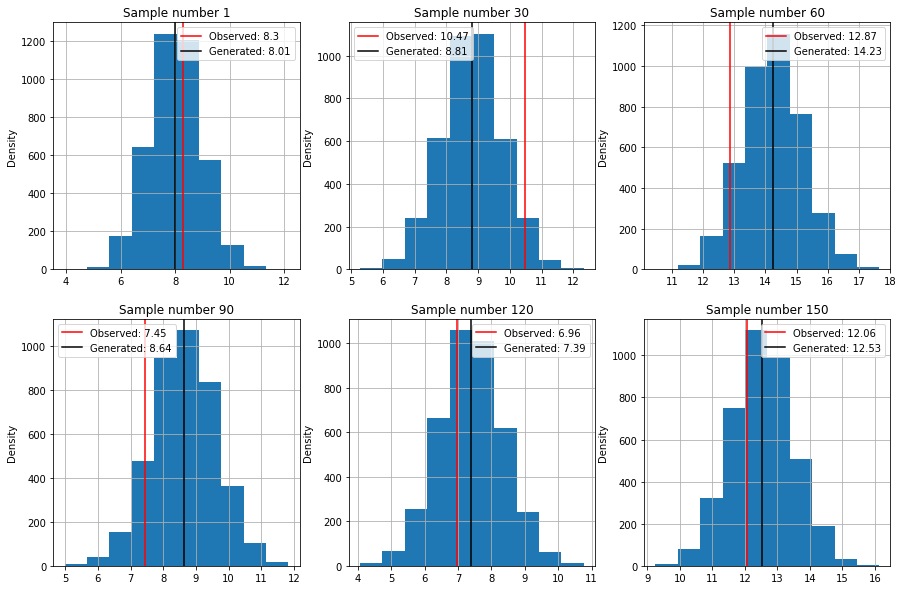

In [70]:
samples_hist(DATA['zużycie (kWh)'], df_1_zuz, 'y_zuzycie_pred_test', [1,30,60,90,120,150])

We can see that model generated values close to observed data. 

Against our expectations, this model behaves quite good despite having some primitive predictors.

## 6. Posterior analysis (model 2)

In [ ]:
# Compile model

model2 = CmdStanModel(stan_file=MODEL_PATH_2_PROD)

sim2_prod = model2.sample(data=data_sim_model2, 
                     seed=123)

df_2 = sim2_prod.draws_pd()

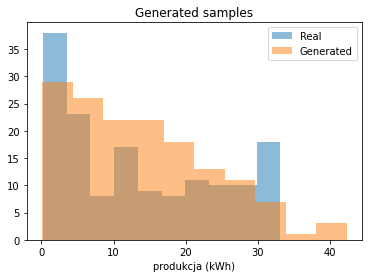

In [72]:
hist_compare(DATA["produkcja (kWh)"], df_2.iloc[0][164:316])

Model 2, in comparison to model 1, still uses normal distributions. However, as seen in the plot, the minimum values reached are close to zero. This is due to the application of the fmax function in the generated quantities. Unfortunately, there are also noticeable values that are larger than the actual data, which may suggest that the temperature used in model 1 had an possitive influence on the prediction.

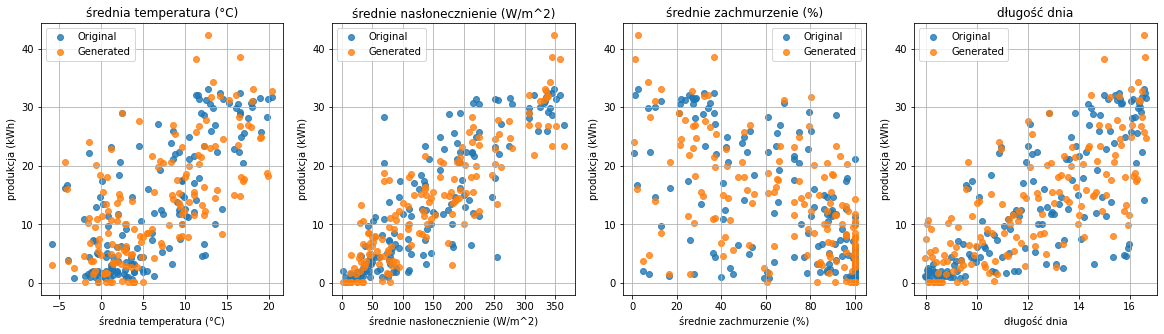

In [73]:
scatter_compare_display(X_produkcja, DATA["produkcja (kWh)"], df_2.iloc[0][164:316])

This model generates data quite well, and it can be said that the values deviating from the norm are even better sampled than in the previous model. However, there are also many samples with values larger than expected.

While the model captures the variability and outliers in the data, the issue of generating values larger than expected remains a concern. It is important to further evaluate and refine the model to address this discrepancy and ensure that the generated samples align more closely with the expected values.

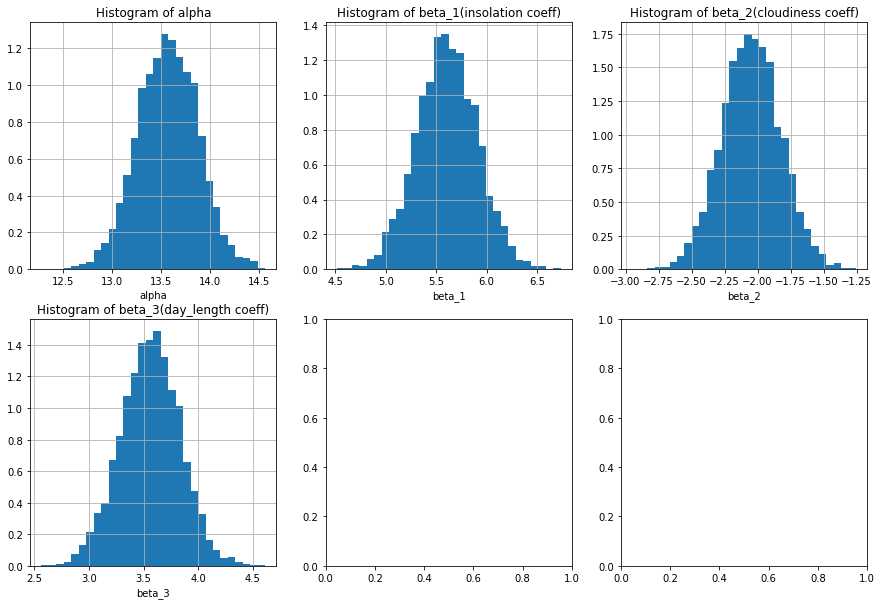

In [74]:
alpha = sim2_prod.stan_variable('a_produkcja')
beta = sim2_prod.stan_variable('beta_produkcja')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].hist(alpha, bins=30, density=True)
axes[0, 0].set_title(f'Histogram of alpha')
axes[0, 0].set_xlabel(f'alpha')
axes[0, 0].grid()

for i, el in enumerate(["insolation coeff", "cloudiness coeff", "day_length coeff"]):
    axes[(i+1)//3, (i+1)%3].hist(beta[:, i], bins=30, density=True)
    axes[(i+1)//3, (i+1)%3].set_title(f'Histogram of beta_{i+1}({el})')
    axes[(i+1)//3, (i+1)%3].set_xlabel(f'beta_{i+1}')
    axes[(i+1)//3, (i+1)%3].grid()

plt.show()

The histograms created from the generated points confirm that the posterior distributions align with the initial assumptions. Posterior model parameter values are slightly shifted in contrast to our prior assumptions, so we can conclude that model learned on input data and corrected its parameter values.

<Figure size 432x288 with 0 Axes>

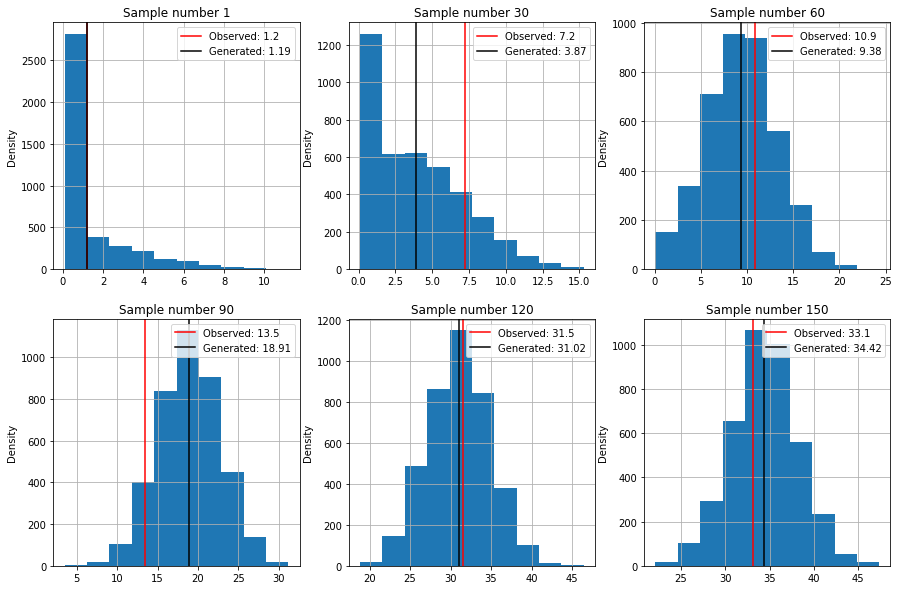

In [75]:
samples_hist(DATA['produkcja (kWh)'], df_2, 'y_produkcja_pred_test', [1,30,60,90,120,150])

Above, similar as in model 1, we created plots of generated values for specific input data. We plotted histograms of values for one day in every month of our data (same days as in model 1), so we could see the influence of predictors on output. As we can see generated data is overall consistent with real values.

## 7. Model comparison

In [76]:
inf_model1_prod = az.from_cmdstanpy(sim1_prod)
inf_model2_prod = az.from_cmdstanpy(sim2_prod)

compare_dict = {
    "model1": inf_model1_prod,
    "model2": inf_model2_prod
}

To compare the models we will use LOO and WAIC criteria. 

### LOO compare

In [77]:
loo_compare = az.compare(compare_dict, ic='loo')
loo_compare.head()

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model1,0,-431.945632,5.219291,0.000000,0.829438,12.567924,0.000000,False,log
model2,1,-447.916701,4.961548,15.971069,0.170562,14.151643,7.454879,False,log


There were no warnings while calculating loo score.

<AxesSubplot:xlabel='Log'>

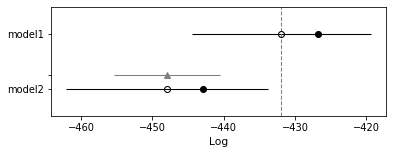

In [78]:
az.plot_compare(loo_compare)

As we can see in loo compare dataframe, Model 1 has better loo score and is higher in ranking. After our analysis we decided that we agree with the result, due to second model generating outliers (above max values of real data). 

### WAIC compare

In [79]:
waic_compare = az.compare(compare_dict, ic='waic')
waic_compare.head()

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model1,0,-431.944000,5.217660,0.000000,0.829263,12.567946,0.00000,True,log
model2,1,-447.907842,4.952689,15.963842,0.170737,14.149887,7.45558,True,log


There were warnings while calculating waic score indicating that the posterior variance of the log predictive densities exceeds 0.4.

<AxesSubplot:xlabel='Log'>

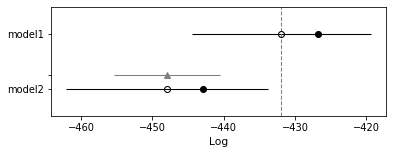

In [80]:
az.plot_compare(waic_compare)

Similar to loo criterium, model 1 again is better - it has better score and higher rank.

Taking into account the individual results and charts for Model 1 and Model 2, as well as considering the parameters for comparing these models, we can conclude that Model 1, which includes more predictors (including temperature), is better and more accurately reflects the real data. Thus, we agree with the ranking of models presented by the LOO and WAIC criteria.

We believe that the first model is superior because temperature does have an impact on predicting data related to the production of energy from photovoltaic panels. Our hypothesis was whether the temperatures reached in Poland are high enough to influence the panel's efficiency. As the comparison of the models has shown, the hypothesis turned out to be true.

<br><br>

In summary, both models reasonably capture the problem of energy production from photovoltaic panels. However, the main issue lies in the generation of negative values in the better-performing model. This issue can potentially be addressed by using different distributions or applying constraints to the parameters.

Improving the models to prevent the generation of negative values would be an important step in enhancing their accuracy and ensuring the generated samples align more closely with the expected values. Exploring alternative distributions or constraints for the parameters could potentially help mitigate this problem and further improve the models' performance.